In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy
import pints.plot
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial

# Define pdf 
# (prior is only used to sample starting positions for chains)
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))

# Set up hyperparameters
initial_parameters = log_prior.sample(n=3)
n_chains = 3

method = pints.HamiltonianMCMC
is_run_parallel = True

n_iterations = 200
warmup = 20

sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=method)
sampler.set_max_iterations(n_iterations)
sampler.set_parallel(is_run_parallel)
sampler.set_log_to_screen(False)

for s in sampler.samplers():
    s.set_leapfrog_step_size(2.0)
    s.set_leapfrog_steps(10)

# Sample
chains = sampler.run()
print(pints.MCMCSummary(chains=chains[:, warmup:]))

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------
param 1  -0.02   1.03    -2.01   -0.66  -0.04  0.65   2.04     1.00    180.00
param 2  0.00    1.05    -2.12   -0.70  0.01   0.69   1.99     1.00    180.00


In [2]:
class BrokenGradientHMC(pints.HamiltonianMCMC):
    """Broken version of Metropolis Hastings.

    The gradient is perturbed by a random value of the specified
    magnitude.
    """
    def __init__(self, x0, sigma0=None):
        super().__init__(x0, sigma0)
        self.grad_error = False
        
    def set_grad_error(self, error):
        self.grad_error = error

    def tell(self, reply):
        energy, gradient = reply
        if self.grad_error:
            gradient *= 0.0
        return super().tell((energy, gradient))
        

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----
param 1  -0.13   1.02    -2.21   -0.79  0.01   0.49   1.80     1.04    57.35
param 2  -0.01   1.02    -1.75   -0.86  -0.10  0.73   2.13     1.04    58.00


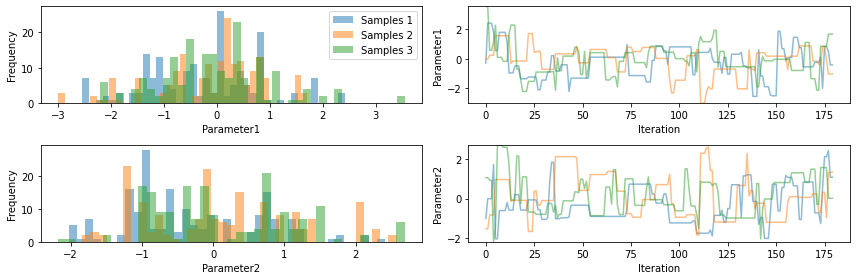

In [3]:
sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=BrokenGradientHMC)
sampler.set_max_iterations(n_iterations)
sampler.set_parallel(is_run_parallel)
sampler.set_log_to_screen(False)

for s in sampler.samplers():
    s.set_leapfrog_step_size(2.0)
    s.set_leapfrog_steps(10)
    s.set_grad_error(True)

# Sample
chains = sampler.run()
print(pints.MCMCSummary(chains=chains[:, warmup:]))

# Plot traces
fig = pints.plot.trace(chains[:,warmup:])
plt.show()

In [4]:
def get_klds_ess(num_runs, start_breaking, grad_error):
    """Run MCMC multiple times, break at some point, and get the KL divs.
    
    It uses the BrokenMH sampler and the 1D Gaussian distribution.

    Parameters
    ----------
    num_runs : int
        Total number of runs
    start_breaking : int
        Which run to break the MCMC algorithm
    error_freq : float
        Error probability per MH step once the algorithm is broken

    Returns
    -------
    list
        List of kl divergences from samples to posterior for each run
    """
    posterior = normal_log_pdf
    x0 = initial_parameters

    klds = []
    ess = []
    for run in range(num_runs):
        mcmc = pints.MCMCController(posterior, 3, x0, method=BrokenGradientHMC)
        mcmc.set_max_iterations(2000)
        
        for s in mcmc.samplers():
            s.set_leapfrog_step_size(2.0)
            s.set_leapfrog_steps(10)
        
        if run >= start_breaking:
            for s in mcmc.samplers():
                s.set_grad_error(grad_error)

        mcmc.set_log_to_screen(False)
        chains = mcmc.run()
        kld = posterior.kl_divergence(chains[0][200:])        
        klds.append(kld)
        
        ess.append(pints.effective_sample_size(chains[0][200:]))

    return klds, ess

In [5]:
def run_changepoint(data):
    """Run changepoint detection using the library.
    """
    ## Set hyperparameters
    # timescale of hazard function
    lam = 250

    # T distribution parameters
    # df=2*self.alpha,
    # loc=self.mu,
    # scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha * self.kappa))
    alpha = 0.1
    beta = 0.0001
    kappa = 1.0
    mu = 0.0

    R, maxes = oncd.online_changepoint_detection(
        data,
        partial(oncd.constant_hazard, lam),
        oncd.StudentT(alpha, beta, kappa, mu))

    return R

In [6]:
random.seed(1000)
np.random.seed(1000)

klds, ess = get_klds_ess(60, 30, True)
ess0 = [x[0] for x in ess]
ess1 = [x[1] for x in ess]



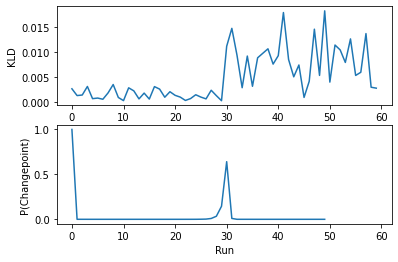

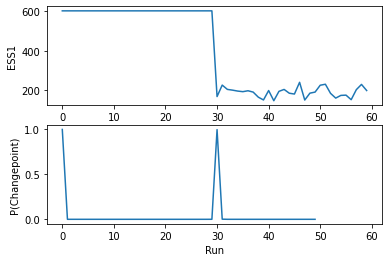

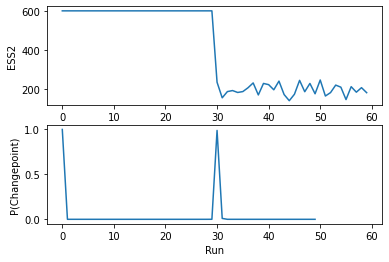

In [7]:
runs = np.arange(len(klds))

R = run_changepoint(klds)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(runs, klds)
ax.set_ylabel('KLD')
ax = fig.add_subplot(2, 1, 2, sharex=ax)
window_size = 10
ax.plot(runs[:-window_size], R[window_size, window_size:-1])
ax.set_xlabel('Run')
ax.set_ylabel('P(Changepoint)')
plt.show()


R = run_changepoint(ess0)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(runs, ess0)
ax.set_ylabel('ESS1')
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(runs[:-window_size], R[window_size, window_size:-1])
ax.set_xlabel('Run')
ax.set_ylabel('P(Changepoint)')
plt.show()


R = run_changepoint(ess1)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(runs, ess1)
ax.set_ylabel('ESS2')
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(runs[:-window_size], R[window_size, window_size:-1])
ax.set_xlabel('Run')
ax.set_ylabel('P(Changepoint)')
plt.show()